In [1]:
import json
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import scipy
from keras import backend as K
from scipy.spatial.distance import cosine as cos_dist

In [2]:
def image_grid(imgs, rows, cols):
    print(len(imgs), "images")
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
def extract_imgs(directory, obj_type):
    # Opening JSON file
    f = open('trial-data/%s/%s.json' % (directory,directory))

    objs = f.readlines()

    imgs[obj_type] = []
    cropped_imgs[obj_type] = []

    for obj in objs:
        # returns JSON object as
        # a dictionary
        data = json.loads(obj)

        json_formatted_str = json.dumps(data, indent=4)
        imgfile = "trial-data/%s/%s.png" % (directory,data['filename'])

        image = Image.open(imgfile)
        draw = ImageDraw.Draw(image)
        
        if data['boundsMinX'] < 0 or data['boundsMinY'] < 0 or\
            data['boundsMaxX'] > 640 or data['boundsMaxY'] > 480:
            continue

        bounds = (data['boundsMinX'],480-data['boundsMaxY'],data['boundsMaxX'],480-data['boundsMinY'])
        cropped_imgs[obj_type].append(image.crop(bounds).resize((84,84)))

        w=2
        draw.line((data['boundsMinX'], 480-data['boundsMinY'], data['boundsMinX'], 480-data['boundsMaxY']), width=w, 
                      fill='red')
        draw.line((data['boundsMinX'], 480-data['boundsMaxY'], data['boundsMaxX'], 480-data['boundsMaxY']), width=w, 
                      fill='red')
        draw.line((data['boundsMaxX'], 480-data['boundsMaxY'], data['boundsMaxX'], 480-data['boundsMinY']), width=w, 
                      fill='red')
        draw.line((data['boundsMaxX'], 480-data['boundsMinY'], data['boundsMinX'], 480-data['boundsMinY']), width=w, 
                      fill='red')
        image = image.resize((160,120))
        imgs[obj_type].append(image)

    # Closing file
    f.close()

In [4]:
imgs = {}
cropped_imgs = {}

In [5]:
extract_imgs('020522-2cubes-stochastic','cube')
extract_imgs('020522-cube_sphere-stochastic','sphere')
extract_imgs('020522-cube_cylinder-stochastic','cylinder')
extract_imgs('020522-cube_capsule-stochastic','capsule')

30 images


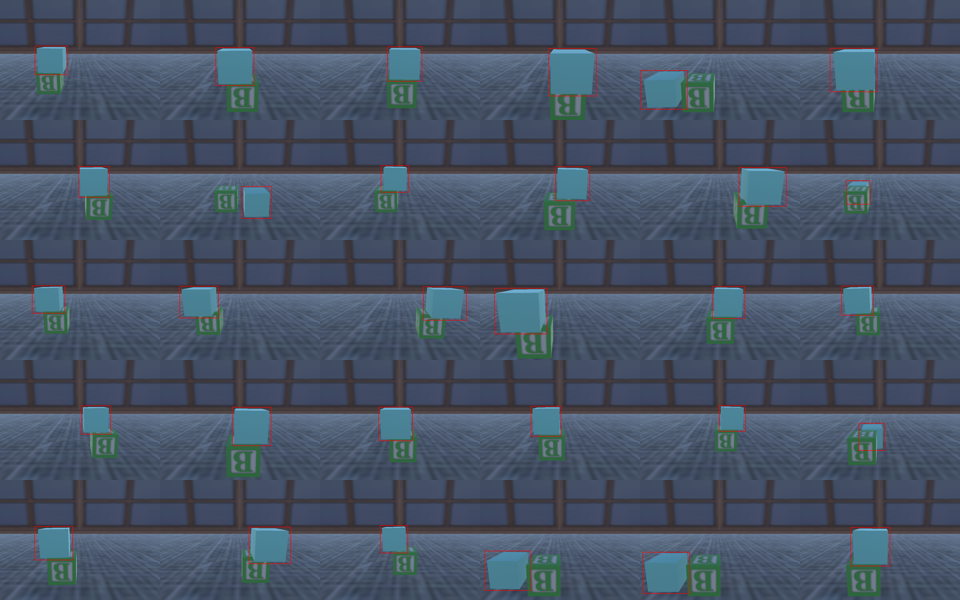

In [6]:
image_grid(imgs['cube'][:30],5,6)

30 images


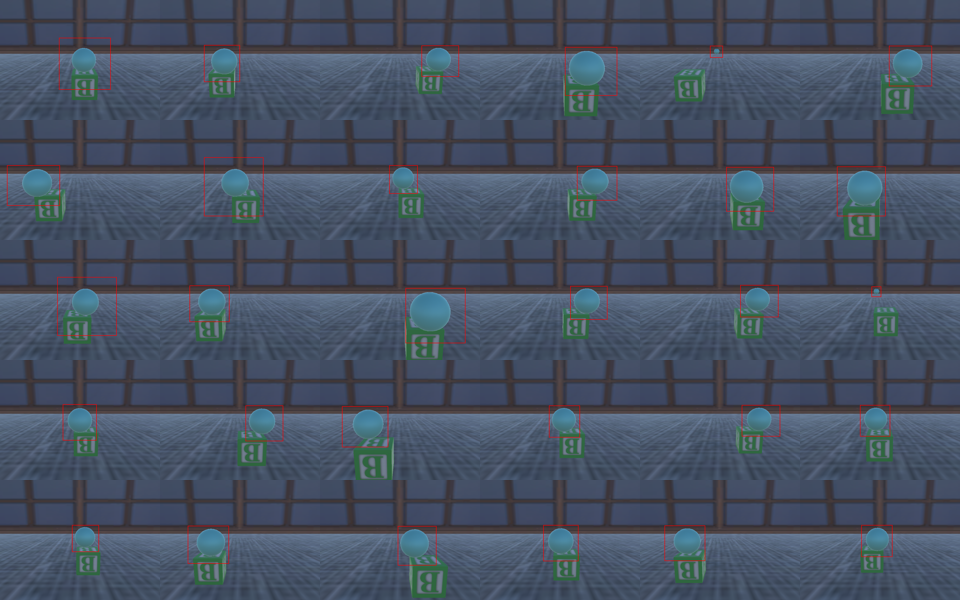

In [7]:
image_grid(imgs['sphere'][:30],5,6)

30 images


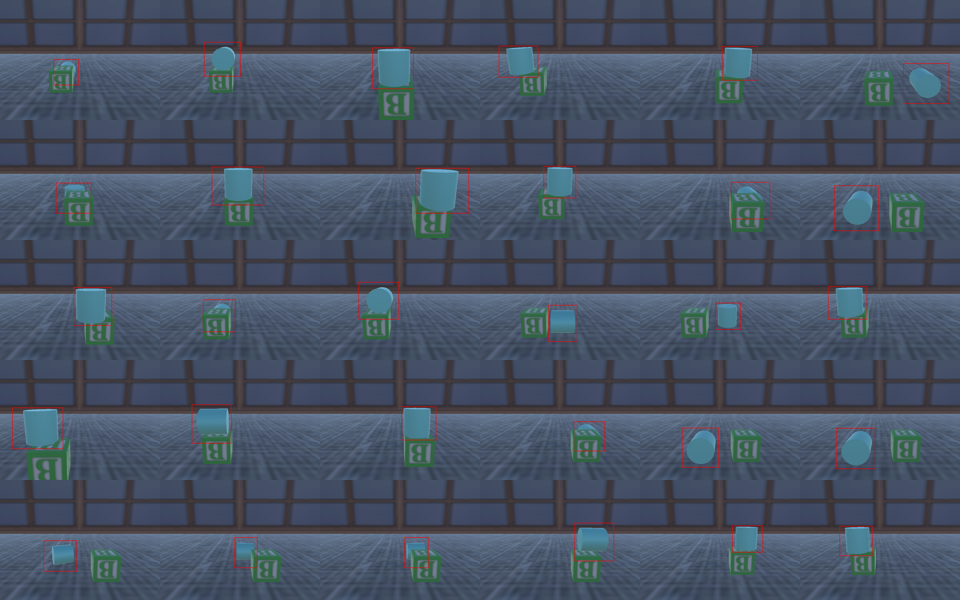

In [8]:
image_grid(imgs['cylinder'][:30],5,6)

30 images


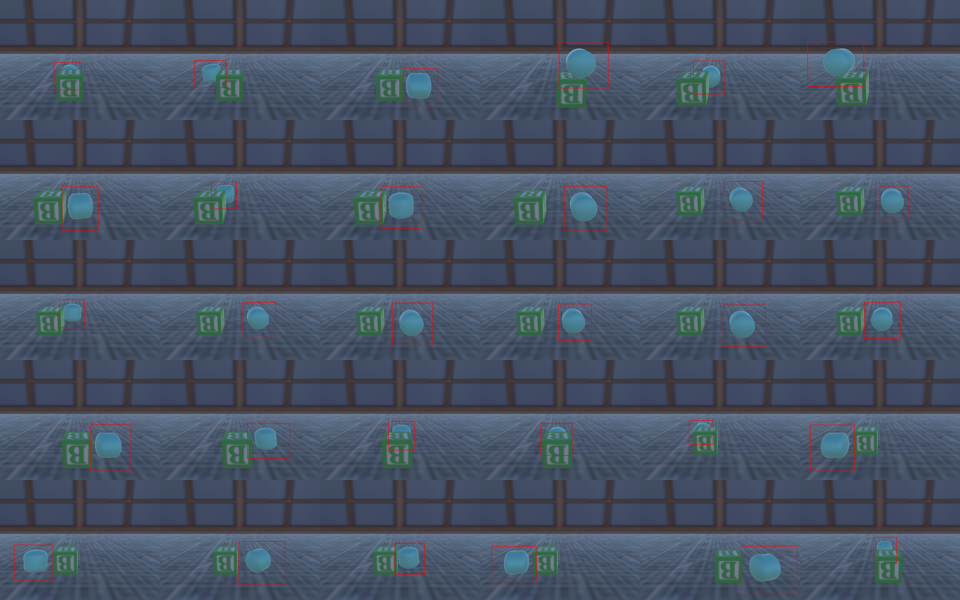

In [9]:
image_grid(imgs['capsule'][:30],5,6)

In [10]:
len(cropped_imgs['cube']),len(cropped_imgs['sphere']),len(cropped_imgs['cylinder']),len(cropped_imgs['capsule'])

(139, 218, 176, 518)

In [11]:
train_imgs = np.vstack([
    np.array([np.array(img)/255 for img in cropped_imgs['cube']][:90]),
    np.array([np.array(img)/255 for img in cropped_imgs['sphere']][:90]),
    np.array([np.array(img)/255 for img in cropped_imgs['cylinder']][:90]),
    np.array([np.array(img)/255 for img in cropped_imgs['capsule']][:90])
])
train_labels = np.vstack([[i]*90 for i in range(int(train_imgs.shape[0]/90))]).reshape(train_imgs.shape[0],1)

val_imgs = np.vstack([
    np.array([np.array(img)/255 for img in cropped_imgs['cube']][90:100]),
    np.array([np.array(img)/255 for img in cropped_imgs['sphere']][90:100]),
    np.array([np.array(img)/255 for img in cropped_imgs['cylinder']][90:100]),
    np.array([np.array(img)/255 for img in cropped_imgs['capsule']][90:100])
])
val_labels = np.vstack([[i]*10 for i in range(int(train_imgs.shape[0]/90))]).reshape(val_imgs.shape[0],1)

train_imgs.shape,val_imgs.shape

((360, 84, 84, 3), (40, 84, 84, 3))

In [12]:
np.max(val_labels)

3

In [34]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(84, 84, 3)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(np.max(val_labels)+1))
model.add(layers.Softmax())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 82, 82, 16)        448       
                                                                 
 average_pooling2d_2 (Averag  (None, 41, 41, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 39, 39, 16)        2320      
                                                                 
 average_pooling2d_3 (Averag  (None, 19, 19, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 16)        2320      
                                                                 
 flatten_1 (Flatten)         (None, 4624)             

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_imgs, train_labels, epochs=500, 
                    validation_data=(val_imgs, val_labels), verbose=2)

Epoch 1/500


2022-02-07 20:48:35.457471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 - 1s - loss: 1.3841 - accuracy: 0.2806 - val_loss: 1.3749 - val_accuracy: 0.2500 - 1s/epoch - 90ms/step


2022-02-07 20:48:36.354008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/500
12/12 - 0s - loss: 1.3588 - accuracy: 0.3278 - val_loss: 1.3233 - val_accuracy: 0.2500 - 161ms/epoch - 13ms/step
Epoch 3/500
12/12 - 0s - loss: 1.2663 - accuracy: 0.6194 - val_loss: 1.1464 - val_accuracy: 0.7250 - 208ms/epoch - 17ms/step
Epoch 4/500
12/12 - 0s - loss: 1.0842 - accuracy: 0.7194 - val_loss: 1.0016 - val_accuracy: 0.7500 - 122ms/epoch - 10ms/step
Epoch 5/500
12/12 - 0s - loss: 0.9850 - accuracy: 0.7861 - val_loss: 0.9648 - val_accuracy: 0.8000 - 160ms/epoch - 13ms/step
Epoch 6/500
12/12 - 0s - loss: 0.9496 - accuracy: 0.8139 - val_loss: 0.9116 - val_accuracy: 0.9000 - 158ms/epoch - 13ms/step
Epoch 7/500
12/12 - 0s - loss: 0.9280 - accuracy: 0.8361 - val_loss: 0.9387 - val_accuracy: 0.8000 - 132ms/epoch - 11ms/step
Epoch 8/500
12/12 - 0s - loss: 0.8996 - accuracy: 0.8694 - val_loss: 0.9278 - val_accuracy: 0.7750 - 156ms/epoch - 13ms/step
Epoch 9/500
12/12 - 0s - loss: 0.8998 - accuracy: 0.8556 - val_loss: 0.8924 - val_accuracy: 0.8250 - 137ms/epoch - 11ms/step


Epoch 68/500
12/12 - 0s - loss: 0.7645 - accuracy: 0.9806 - val_loss: 0.8076 - val_accuracy: 0.9250 - 154ms/epoch - 13ms/step
Epoch 69/500
12/12 - 0s - loss: 0.7631 - accuracy: 0.9833 - val_loss: 0.7752 - val_accuracy: 1.0000 - 155ms/epoch - 13ms/step
Epoch 70/500
12/12 - 0s - loss: 0.7635 - accuracy: 0.9806 - val_loss: 0.7860 - val_accuracy: 0.9500 - 159ms/epoch - 13ms/step
Epoch 71/500
12/12 - 0s - loss: 0.7621 - accuracy: 0.9833 - val_loss: 0.7668 - val_accuracy: 1.0000 - 160ms/epoch - 13ms/step
Epoch 72/500
12/12 - 0s - loss: 0.7619 - accuracy: 0.9833 - val_loss: 0.8085 - val_accuracy: 0.9250 - 163ms/epoch - 14ms/step
Epoch 73/500
12/12 - 0s - loss: 0.7635 - accuracy: 0.9833 - val_loss: 0.8005 - val_accuracy: 0.9500 - 164ms/epoch - 14ms/step
Epoch 74/500
12/12 - 0s - loss: 0.7626 - accuracy: 0.9833 - val_loss: 0.7867 - val_accuracy: 0.9750 - 158ms/epoch - 13ms/step
Epoch 75/500
12/12 - 0s - loss: 0.7618 - accuracy: 0.9833 - val_loss: 0.7848 - val_accuracy: 0.9750 - 157ms/epoch - 13

Epoch 133/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7762 - val_accuracy: 0.9750 - 153ms/epoch - 13ms/step
Epoch 134/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7783 - val_accuracy: 0.9750 - 155ms/epoch - 13ms/step
Epoch 135/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7796 - val_accuracy: 0.9750 - 154ms/epoch - 13ms/step
Epoch 136/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7787 - val_accuracy: 0.9750 - 153ms/epoch - 13ms/step
Epoch 137/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7762 - val_accuracy: 0.9750 - 150ms/epoch - 13ms/step
Epoch 138/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7778 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 139/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7787 - val_accuracy: 0.9750 - 150ms/epoch - 12ms/step
Epoch 140/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7766 - val_accuracy: 0.9750 - 154ms/ep

Epoch 198/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7775 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 199/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7771 - val_accuracy: 0.9750 - 143ms/epoch - 12ms/step
Epoch 200/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7774 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 201/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7770 - val_accuracy: 0.9750 - 150ms/epoch - 13ms/step
Epoch 202/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7784 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 203/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7781 - val_accuracy: 0.9750 - 147ms/epoch - 12ms/step
Epoch 204/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7784 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 205/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7763 - val_accuracy: 0.9750 - 148ms/ep

Epoch 263/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7770 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 264/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7787 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 265/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7781 - val_accuracy: 0.9750 - 158ms/epoch - 13ms/step
Epoch 266/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7798 - val_accuracy: 0.9750 - 149ms/epoch - 12ms/step
Epoch 267/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7754 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 268/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7778 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 269/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7768 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 270/500
12/12 - 0s - loss: 0.7604 - accuracy: 0.9833 - val_loss: 0.7775 - val_accuracy: 0.9750 - 152ms/ep

Epoch 328/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7769 - val_accuracy: 0.9750 - 149ms/epoch - 12ms/step
Epoch 329/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7765 - val_accuracy: 0.9750 - 153ms/epoch - 13ms/step
Epoch 330/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7768 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 331/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7783 - val_accuracy: 0.9750 - 150ms/epoch - 13ms/step
Epoch 332/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7767 - val_accuracy: 0.9750 - 149ms/epoch - 12ms/step
Epoch 333/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7767 - val_accuracy: 0.9750 - 149ms/epoch - 12ms/step
Epoch 334/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7771 - val_accuracy: 0.9750 - 153ms/epoch - 13ms/step
Epoch 335/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7771 - val_accuracy: 0.9750 - 151ms/ep

Epoch 393/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7771 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 394/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7791 - val_accuracy: 0.9750 - 161ms/epoch - 13ms/step
Epoch 395/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7775 - val_accuracy: 0.9750 - 159ms/epoch - 13ms/step
Epoch 396/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7769 - val_accuracy: 0.9750 - 152ms/epoch - 13ms/step
Epoch 397/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7770 - val_accuracy: 0.9750 - 151ms/epoch - 13ms/step
Epoch 398/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7779 - val_accuracy: 0.9750 - 156ms/epoch - 13ms/step
Epoch 399/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7772 - val_accuracy: 0.9750 - 157ms/epoch - 13ms/step
Epoch 400/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7772 - val_accuracy: 0.9750 - 155ms/ep

Epoch 458/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7774 - val_accuracy: 0.9750 - 275ms/epoch - 23ms/step
Epoch 459/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7774 - val_accuracy: 0.9750 - 175ms/epoch - 15ms/step
Epoch 460/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7759 - val_accuracy: 0.9750 - 162ms/epoch - 13ms/step
Epoch 461/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7767 - val_accuracy: 0.9750 - 193ms/epoch - 16ms/step
Epoch 462/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7780 - val_accuracy: 0.9750 - 178ms/epoch - 15ms/step
Epoch 463/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7772 - val_accuracy: 0.9750 - 183ms/epoch - 15ms/step
Epoch 464/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7767 - val_accuracy: 0.9750 - 172ms/epoch - 14ms/step
Epoch 465/500
12/12 - 0s - loss: 0.7603 - accuracy: 0.9833 - val_loss: 0.7773 - val_accuracy: 0.9750 - 174ms/ep

2/2 - 0s - loss: 0.7761 - accuracy: 0.9750 - 199ms/epoch - 99ms/step


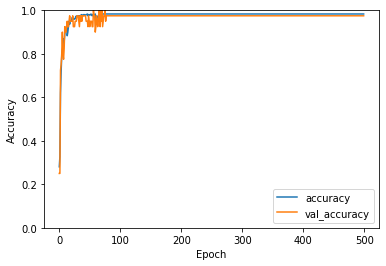

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(val_imgs,  val_labels, verbose=2)

In [37]:
print(val_acc)

0.9750000238418579


2022-02-07 20:53:27.691869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


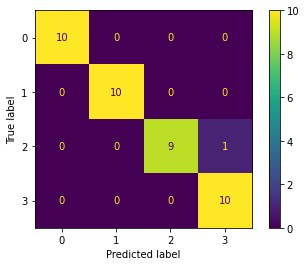

In [38]:
predictions = model.predict(val_imgs)
classes = np.argmax(predictions,axis=1)
#print(predictions,classes)
cm = sklearn.metrics.confusion_matrix(val_labels, classes)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [39]:
get_embeddings = K.function([model.layers[0].input],
                                  [model.layers[-3].output])

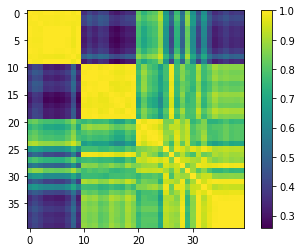

In [40]:
embeddings = get_embeddings(val_imgs)[0]
size = len(embeddings)
mat = np.array([1-cos_dist(embeddings[i],embeddings[j]) for i in range(size) for j in range(size)]).\
    reshape(size,size)
plt.imshow(mat)
plt.colorbar()

In [41]:
test_imgs = np.vstack([
    np.array([np.array(img)/255 for img in cropped_imgs['cube']][100:135]),
    np.array([np.array(img)/255 for img in cropped_imgs['sphere']][100:135]),
    np.array([np.array(img)/255 for img in cropped_imgs['cylinder']][100:135]),
    np.array([np.array(img)/255 for img in cropped_imgs['capsule']][100:135])
])
test_labels = np.vstack([[i]*35 for i in range(int(test_imgs.shape[0]/35))]).reshape(test_imgs.shape[0],1)

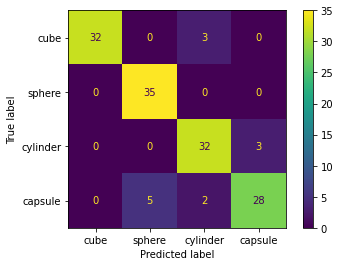

In [45]:
predictions = model.predict(test_imgs)
classes = np.argmax(predictions,axis=1)
cm = sklearn.metrics.confusion_matrix(test_labels, classes)
disp = ConfusionMatrixDisplay(cm, display_labels=["cube", "sphere", "cylinder", "capsule"])
disp.plot()

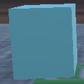

correct: 0
predicted: 2


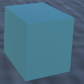

correct: 0
predicted: 2


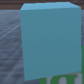

correct: 0
predicted: 2


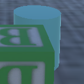

correct: 2
predicted: 3


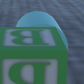

correct: 2
predicted: 3


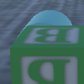

correct: 2
predicted: 3


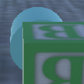

correct: 2
predicted: 3


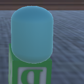

correct: 3
predicted: 2


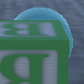

correct: 3
predicted: 2


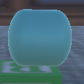

correct: 3
predicted: 1


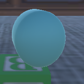

correct: 3
predicted: 1


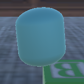

correct: 3
predicted: 1


In [32]:
correct = test_labels[np.where(classes != test_labels.reshape(1,-1))[1]].reshape(1,-1)[0]
predicted = classes[np.where(classes != test_labels.reshape(1,-1))[1]]
mislabels = [Image.fromarray(np.uint8(img*255)) for img in test_imgs[np.where(classes != test_labels.reshape(1,-1))[1]]]

for i in range(len(mislabels)):
    display(mislabels[i])
    print("correct: %s\npredicted: %s" % (correct[i],predicted[i]))

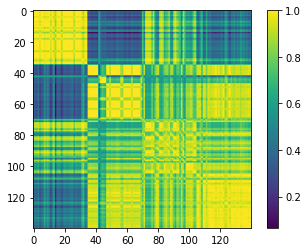

In [33]:
embeddings = get_embeddings(test_imgs)[0]
size = len(embeddings)
mat = np.array([1-cos_dist(embeddings[i],embeddings[j]) for i in range(size) for j in range(size)]).\
    reshape(size,size)
plt.imshow(mat)
plt.colorbar()